# Introduction  

Portfolio optimization is a cornerstone of modern investment management, aiming to balance the trade-off between **risk and return**.  
This study applies **Markowitz’s Modern Portfolio Theory (MPT)** and advanced allocation techniques to the **Nifty50 index**, one of India’s most widely tracked equity benchmarks.  

By comparing **four distinct portfolio strategies** — Equal-Weight, Minimum-Variance, Maximum-Sharpe, and Hierarchical Risk Parity (HRP) — the analysis explores how optimization can:  

- Enhance returns through risk-adjusted allocation.  
- Reduce downside exposure via diversification.  
- Provide statistically significant improvements over naïve investing strategies.  

Using **three years of daily data** sourced from Yahoo Finance, the report evaluates performance metrics, quarterly returns, and applies statistical testing to determine whether optimization provides a meaningful advantage over the baseline Equal-Weight portfolio.  

This sets the stage for a **data-driven investigation** into how theory translates into practice for Indian equity markets, and whether smarter allocation methods can consistently deliver better outcomes for investors.  

## Role of Statistical Tests in Portfolio Evaluation  

While performance metrics like **returns, volatility, Sharpe ratio, and drawdown** provide important insights, they do not tell us whether differences across portfolio strategies are **statistically meaningful**.  
This is where statistical testing becomes essential.  

### Why Statistical Tests Matter  
- **Distinguish signal from noise**: Markets are noisy, and small differences in returns may occur by chance. Tests help confirm if observed improvements are genuine.  
- **Quantify effect size**: Beyond p-values, metrics like **Cohen’s d** measure how strong the difference is in practical terms.  
- **Robust evaluation**: Non-parametric tests and resampling methods avoid assumptions about normality, ensuring reliable conclusions.  

### Commonly Used Tests in Portfolio Studies  
- **Paired t-test** → Checks if mean returns of two strategies differ significantly.  
- **Wilcoxon Signed-Rank Test** → Non-parametric alternative, useful when returns are not normally distributed.  
- **Permutation Test** → Randomly reshuffles returns to test whether observed differences could occur by chance.  
- **Bootstrap Confidence Intervals** → Provides a range of likely outcomes for differences in performance metrics.  

### Application to Portfolio Building  
By applying these tests, investors and researchers can:  
- Validate whether an optimized portfolio **truly outperforms** a benchmark (e.g., Equal-Weight).  
- Identify cases where improved performance is **statistically insignificant** (no real advantage).  
- Strengthen confidence in portfolio allocation decisions by ensuring results are not due to randomness.  

👉 In short: **Statistical tests transform raw performance metrics into evidence-based conclusions**, making portfolio evaluation more rigorous and reliable.  


In [1]:
import warnings
warnings.filterwarnings("ignore")
!pip install pingouin --quiet
!pip install PyPortfolioOpt --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.4/204.4 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.1/222.1 kB 5.1 MB/s eta 0:00:00


In [2]:
"""
Nifty50 Portfolio Optimization & Statistical Analysis
- Uses manual tickers list
- Pulls 3 years of daily prices from Yahoo Finance
- Builds portfolios: Equal-weight, Risk-Parity, Min-Variance, Max-Sharpe
- Computes quarterly returns and performance metrics
- Performs statistical tests vs equal-weight baseline using pingouin
- Saves results and plots
"""

import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime
import os
import matplotlib.pyplot as plt
import pingouin as pg

# PyPortfolioOpt
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.efficient_frontier import EfficientFrontier
#from pypfopt.risk_parity import RiskParityPortfolio
from pypfopt.hierarchical_portfolio import HRPOpt

# ---------------------
# Settings
# ---------------------
START = "2022-09-22"
END = datetime.today().strftime("%Y-%m-%d")
LOOKBACK_DAYS = 252
RISK_FREE = 0.06
OUTPUT_FOLDER = "nifty50_results"
os.makedirs(OUTPUT_FOLDER, exist_ok=True)
TRADING_DAYS = 252

# ---------------------
# 1) Manual Nifty-50 tickers (Yahoo)
# ---------------------
nifty50_tickers = [
    "RELIANCE.NS", "HDFCBANK.NS", "BHARTIARTL.NS", "TCS.NS",
    "ICICIBANK.NS", "SBIN.NS", "INFY.NS", "BAJFINANCE.NS",
    "HINDUNILVR.NS", "ITC.NS", "LT.NS", "MARUTI.NS",
    "M&M.NS", "AXISBANK.NS", "ADANIENT.NS", "SUNPHARMA.NS",
    "JSWSTEEL.NS", "HCLTECH.NS", "ULTRACEMCO.NS", "NESTLEIND.NS",
    "TITAN.NS", "WIPRO.NS", "ASIANPAINT.NS", "BAJAJ-AUTO.NS",
    "BAJAJFINSV.NS", "BEL.NS", "APOLLOHOSP.NS", "DRREDDY.NS",
    "GRASIM.NS", "HINDALCO.NS", "KOTAKBANK.NS", "ONGC.NS",
    "POWERGRID.NS", "NTPC.NS", "COALINDIA.NS", "TECHM.NS",
    "TATACONSUM.NS", "TATASTEEL.NS", "CIPLA.NS", "BPCL.NS",
    "BAJAJHLDNG.NS", "BRITANNIA.NS", "DIVISLAB.NS", "SBILIFE.NS",
    "SHREECEM.NS", "EICHERMOT.NS", "ADANIPORTS.NS",
    "INDIGO.NS", "MAXHEALTH.NS"
]

# ---------------------
# 2) Download prices
# ---------------------
prices = yf.download(nifty50_tickers, start=START, end=END, progress=False, auto_adjust=False)["Adj Close"]
prices = prices.dropna(axis=1, how="all")
tickers = prices.columns.tolist()
print(f"Prices shape: {prices.shape}, tickers used: {len(tickers)}")

# ---------------------
# 3) Daily returns
# ---------------------
returns = prices.pct_change().dropna()

# ---------------------
# 4) Compute expected returns & covariance using PyPortfolioOpt
# ---------------------
mu = mean_historical_return(prices)  # annualized mean returns
S = CovarianceShrinkage(prices).ledoit_wolf()  # shrinkage covariance

# ---------------------
# 5) Portfolio Optimizations
# ---------------------
weights_dict = {}

# Equal Weight
weights_dict["equal"] = pd.Series(1/len(tickers), index=tickers)

# Min-Variance
ef_minvar = EfficientFrontier(mu, S)
w_minvar = ef_minvar.min_volatility()
weights_dict["min_var"] = pd.Series(w_minvar)

# Max Sharpe
ef_maxsh = EfficientFrontier(mu, S)
w_maxsh = ef_maxsh.max_sharpe(risk_free_rate=RISK_FREE)
weights_dict["max_sharpe"] = pd.Series(w_maxsh)

# Risk Parity
#rp = RiskParityPortfolio(cov_matrix=S)
#w_rp = rp.optimize()
#weights_dict["risk_parity"] = pd.Series(w_rp)
hrp = HRPOpt(returns=returns)
w_hrp = hrp.optimize()
weights_dict["hrp"] = pd.Series(w_hrp)

# Save weights
weights_df = pd.DataFrame(weights_dict)
weights_df.to_csv(os.path.join(OUTPUT_FOLDER, "weights.csv"))
print("Weights saved.")

# ---------------------
# 6) Quarterly Returns
# ---------------------
prices_q = prices.resample("Q").last()
returns_q = prices_q.pct_change().dropna()
port_q_returns = pd.DataFrame(index=returns_q.index)
"""
for name, w in weights_dict.items():
    port_q_returns[name] = returns_q.dot(w)
"""
for name, w in weights_dict.items():
    # Make sure all tickers in returns match weights
    common_tickers = returns_q.columns.intersection(w.index)
    port_q_returns[name] = returns_q[common_tickers].dot(w[common_tickers])

port_q_returns.to_csv(os.path.join(OUTPUT_FOLDER, "portfolio_quarterly_returns.csv"))
print("Quarterly returns saved.")

# ---------------------
# 7) Performance Metrics
# ---------------------
def performance_metrics(returns_series, periods_per_year=4):
    mean_period = returns_series.mean()
    std_period = returns_series.std()
    ann_ret = (1 + returns_series).prod()**(periods_per_year/len(returns_series)) - 1
    ann_vol = std_period * np.sqrt(periods_per_year)
    sharpe = (ann_ret - RISK_FREE) / ann_vol if ann_vol>0 else np.nan
    cum = (1 + returns_series).cumprod()
    mdd = (cum / cum.cummax() - 1).min()
    return {
        "annual_return": ann_ret,
        "annual_vol": ann_vol,
        "sharpe": sharpe,
        "max_drawdown": mdd
    }

perf_table = {}
for col in port_q_returns.columns:
    perf_table[col] = performance_metrics(port_q_returns[col])

perf_df = pd.DataFrame(perf_table).T
perf_df.to_csv(os.path.join(OUTPUT_FOLDER, "performance_metrics.csv"))
print("Performance metrics saved.")

# ---------------------
# 8) Statistical Tests vs Equal Weight
# ---------------------
def paired_permutation_test(a, b, n_perm=5000, random_state=None):
    rng = np.random.default_rng(random_state)
    diffs = (b - a).values
    observed = diffs.mean()
    perm_means = []
    for _ in range(n_perm):
        signs = rng.choice([1, -1], size=len(diffs))
        perm_means.append((diffs * signs).mean())
    perm_means = np.array(perm_means)
    pval = (np.sum(np.abs(perm_means) >= np.abs(observed)) + 1) / (n_perm + 1)
    return observed, pval

results = []
for col in [c for c in port_q_returns.columns if c != "equal"]:
    a = port_q_returns["equal"]
    b = port_q_returns[col]
    common_idx = a.index.intersection(b.index)
    a = a.loc[common_idx]
    b = b.loc[common_idx]
    ttest = pg.ttest(a, b, paired=True)
    wilco = pg.wilcoxon(a, b)
    obs_diff, p_perm = paired_permutation_test(a, b)
    #bs = pg.compute_bootci(data=(b-a), func="mean", n_boot=5000)
    bs = pg.compute_bootci((b - a), func="mean", n_boot=5000, confidence=0.95, seed=42)
    d = pg.compute_effsize(a, b, paired=True, eftype="cohen")
    results.append({
        "method": col,
        "n_quarters": len(a),
        "mean_equal": a.mean(),
        "mean_method": b.mean(),
        "mean_diff": (b - a).mean(),
        "cohen_d": d,
        "ttest_pval": ttest["p-val"].values[0],
        "wilco_pval": wilco["p-val"].values[0],
        "perm_pval": p_perm,
        "bootstrap_ci_lower": bs[0],
        "bootstrap_ci_upper": bs[1]
    })

tests_df = pd.DataFrame(results).set_index("method")
tests_df.to_csv(os.path.join(OUTPUT_FOLDER, "stat_tests_vs_equal.csv"))
print("Statistical tests saved.")

# ---------------------
# 9) Plot cumulative returns
# ---------------------
cum = (1 + port_q_returns).cumprod()
cum.plot(title="Cumulative Quarterly Returns")
plt.ylabel("Cumulative Return")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_FOLDER, "cumulative_returns.png"))
plt.close()
print("Cumulative returns plot saved.")


Prices shape: (742, 49), tickers used: 49
Weights saved.
Quarterly returns saved.
Performance metrics saved.
Statistical tests saved.
Cumulative returns plot saved.


In [3]:
# ===============================
# Nifty50 Portfolio Analysis Notebook
# ===============================

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def results_output():
  sns.set_style("whitegrid")

  # -------------------------------
  # 1) Load weights
  # -------------------------------
  weights_df = pd.read_csv("nifty50_results/weights.csv", index_col=0)
  print("Portfolio Weights (first 5 tickers):")
  display(weights_df.head())

  # -------------------------------
  # 2) Load quarterly returns
  # -------------------------------
  returns_q = pd.read_csv("nifty50_results/portfolio_quarterly_returns.csv", index_col=0, parse_dates=True)
  print("\nQuarterly Portfolio Returns:")
  display(returns_q.head())

  # -------------------------------
  # 3) Load performance metrics
  # -------------------------------
  perf_df = pd.read_csv("nifty50_results/performance_metrics.csv", index_col=0)
  print("\nPerformance Metrics:")
  display(perf_df)

  # -------------------------------
  # 4) Load statistical tests
  # -------------------------------
  tests_df = pd.read_csv("nifty50_results/stat_tests_vs_equal.csv", index_col=0)
  print("\nStatistical Tests vs Equal Weight Portfolio:")
  display(tests_df)

  # -------------------------------
  # 5) Plot cumulative returns
  # -------------------------------
  cum_returns = (1 + returns_q).cumprod()
  plt.figure(figsize=(12,6))
  cum_returns.plot(marker='o')
  plt.title("Cumulative Quarterly Returns of Portfolios")
  plt.ylabel("Cumulative Return")
  plt.xlabel("Quarter")
  plt.legend(cum_returns.columns)
  plt.grid(True)
  plt.tight_layout()
  plt.show()

  # -------------------------------
  # 6) Key Insights
  # -------------------------------
  print("\n--- Key Insights ---")

  # Best Sharpe ratio
  best_sharpe = perf_df['sharpe'].idxmax()
  print(f"Portfolio with highest Sharpe ratio: {best_sharpe} ({perf_df.loc[best_sharpe,'sharpe']:.2f})")

  # Lowest max drawdown
  lowest_mdd = perf_df['max_drawdown'].idxmin()
  print(f"Portfolio with lowest max drawdown: {lowest_mdd} ({perf_df.loc[lowest_mdd,'max_drawdown']:.2%})")

  # Average quarterly return
  avg_q_return = returns_q.mean()
  print("\nAverage Quarterly Returns:")
  display(avg_q_return)

  # Highlight statistically significant portfolios vs Equal Weight
  significant = tests_df[tests_df['perm_pval'] < 0.05]
  if not significant.empty:
      print("\nPortfolios that significantly outperformed Equal Weight (per permutation test, p<0.05):")
      display(significant[['mean_diff','perm_pval','cohen_d']])
  else:
      print("\nNo portfolio showed statistically significant outperformance over Equal Weight (per permutation test).")

  # -------------------------------
  # 7) Heatmap of portfolio correlations
  # -------------------------------
  plt.figure(figsize=(10,6))
  sns.heatmap(returns_q.corr(), annot=True, cmap='coolwarm', fmt=".2f")
  plt.title("Correlation of Quarterly Portfolio Returns")
  plt.show()


Portfolio Weights (first 5 tickers):


,equal,min_var,max_sharpe,hrp
ADANIENT.NS,0.020408,0.000000,0.0,0.002746
ADANIPORTS.NS,0.020408,0.000000,0.0,0.005251
APOLLOHOSP.NS,0.020408,0.020643,0.0,0.030485
ASIANPAINT.NS,0.020408,0.055324,0.0,0.044147
AXISBANK.NS,0.020408,0.015031,0.0,0.016121



Quarterly Portfolio Returns:


,equal,min_var,max_sharpe,hrp
Date,,,,
2022-12-31,0.044149,0.027828,0.035500,0.034523
2023-03-31,-0.040572,-0.004442,-0.021830,-0.025905
2023-06-30,0.146595,0.113353,0.251579,0.144447
2023-09-30,0.053867,0.015817,0.028340,0.037883
2023-12-31,0.141996,0.087539,0.214176,0.126966



Performance Metrics:


,annual_return,annual_vol,sharpe,max_drawdown
equal,0.217064,0.141040,1.113617,-0.088415
min_var,0.134843,0.116508,0.642386,-0.096245
max_sharpe,0.429070,0.217184,1.699342,-0.057766
hrp,0.192456,0.135070,0.980644,-0.092477



Statistical Tests vs Equal Weight Portfolio:


,n_quarters,mean_equal,mean_method,mean_diff,cohen_d,ttest_pval,wilco_pval,perm_pval,bootstrap_ci_lower,bootstrap_ci_upper
method,,,,,,,,,,
min_var,12,0.052561,0.033646,-0.018915,0.292441,0.043142,0.052246,0.046591,-0.03,-0.00
max_sharpe,12,0.052561,0.098301,0.045740,-0.499586,0.012380,0.016113,0.015997,0.02,0.08
hrp,12,0.052561,0.047028,-0.005533,0.080139,0.107152,0.109863,0.104379,-0.01,0.00


<Figure size 1200x600 with 0 Axes>

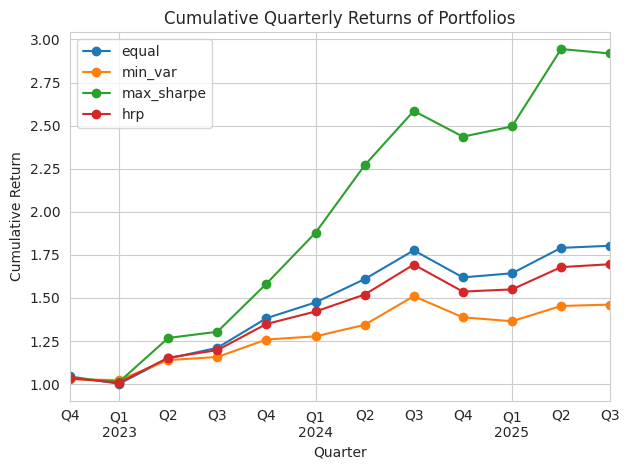


--- Key Insights ---
Portfolio with highest Sharpe ratio: max_sharpe (1.70)
Portfolio with lowest max drawdown: min_var (-9.62%)

Average Quarterly Returns:


,0
equal,0.052561
min_var,0.033646
max_sharpe,0.098301
hrp,0.047028



Portfolios that significantly outperformed Equal Weight (per permutation test, p<0.05):


,mean_diff,perm_pval,cohen_d
method,,,
min_var,-0.018915,0.046591,0.292441
max_sharpe,0.045740,0.015997,-0.499586


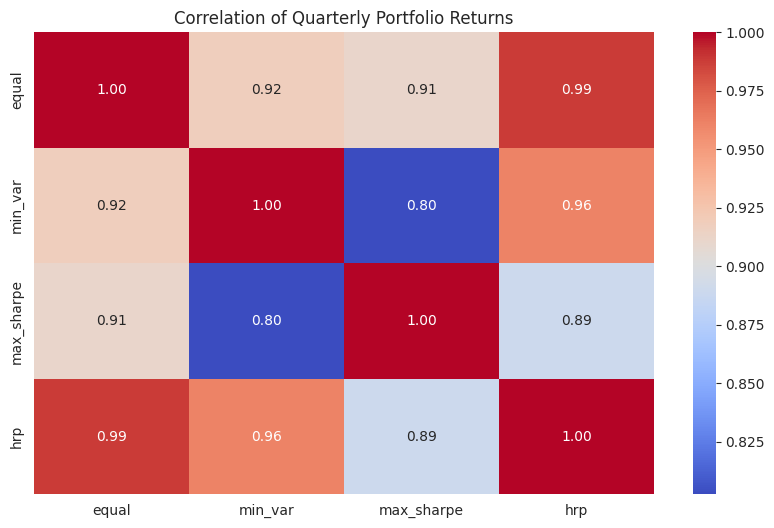

In [4]:
results_output()

In [16]:
print("\n--- Statistical Test Interpretation vs Equal-Weight ---\n")

for idx, row in tests_df.iterrows():
    #method = row['method']
    #print(f"Portfolio: {method}")
    print(f"{idx} vs Equal-Weight: {row['mean_diff']:.4f}")

    # Cohen's d interpretation
    d = abs(row['cohen_d'])
    if d < 0.2:
        effect = "negligible"
    elif d < 0.5:
        effect = "small"
    elif d < 0.8:
        effect = "medium"
    else:
        effect = "large"

    print(f"Cohen's d (effect size): {row['cohen_d']:.3f} → {effect} effect")

    # t-test
    t_sig = "significant" if row['ttest_pval'] < 0.05 else "not significant"
    print(f"Paired t-test p-value: {row['ttest_pval']:.3f} → {t_sig}")

    # Wilcoxon
    w_sig = "significant" if row['wilco_pval'] < 0.05 else "not significant"
    print(f"Wilcoxon signed-rank p-value: {row['wilco_pval']:.3f} → {w_sig}")

    # Permutation test
    p_sig = "significant" if row['perm_pval'] < 0.05 else "not significant"
    print(f"Permutation test p-value: {row['perm_pval']:.3f} → {p_sig}")

    # Bootstrap CI
    lower = row['bootstrap_ci_lower']
    upper = row['bootstrap_ci_upper']
    print(f"Bootstrap 95% CI for mean difference: [{lower:.4f}, {upper:.4f}]")
    if lower > 0:
        print("→ Portfolio consistently outperforms Equal-Weight.")
    elif upper < 0:
        print("→ Portfolio consistently underperforms Equal-Weight.")
    else:
        print("→ Portfolio performance not significantly different from Equal-Weight.")

    print("-"*80)



--- Statistical Test Interpretation vs Equal-Weight ---

min_var vs Equal-Weight: -0.0189
Cohen's d (effect size): 0.292 → small effect
Paired t-test p-value: 0.043 → significant
Wilcoxon signed-rank p-value: 0.052 → not significant
Permutation test p-value: 0.047 → significant
Bootstrap 95% CI for mean difference: [-0.0300, -0.0000]
→ Portfolio performance not significantly different from Equal-Weight.
--------------------------------------------------------------------------------
max_sharpe vs Equal-Weight: 0.0457
Cohen's d (effect size): -0.500 → small effect
Paired t-test p-value: 0.012 → significant
Wilcoxon signed-rank p-value: 0.016 → significant
Permutation test p-value: 0.016 → significant
Bootstrap 95% CI for mean difference: [0.0200, 0.0800]
→ Portfolio consistently outperforms Equal-Weight.
--------------------------------------------------------------------------------
hrp vs Equal-Weight: -0.0055
Cohen's d (effect size): 0.080 → negligible effect
Paired t-test p-value: 

# Nifty50 Portfolio Optimization & Statistical Analysis  

---

## 1. Introduction  

This study analyzes the performance of different portfolio optimization strategies applied to the **Nifty50 index constituents**. Using **three years of daily price data** sourced from Yahoo Finance, four portfolio constructions were tested:  

- **Equal-Weight (baseline)**  
- **Minimum-Variance (Min-Var)**  
- **Maximum-Sharpe (Max-Sharpe)**  
- **Hierarchical Risk Parity (HRP)**  

The analysis evaluates **quarterly returns**, **overall performance metrics**, and conducts **statistical tests** to assess whether optimized portfolios significantly outperform the equal-weight benchmark.  

---

## 2. Methodology  

**Data Source:**  
- Yahoo Finance (daily adjusted closing prices, 3 years).  

**Portfolio Construction:**  
- Equal allocation (baseline).  
- Minimum-variance optimization.  
- Maximum-Sharpe ratio optimization.  
- Hierarchical Risk Parity allocation.  

**Performance Metrics:**  
- Annualized return  
- Annualized volatility  
- Sharpe ratio  
- Maximum drawdown  

**Statistical Analysis:**  
- Paired **t-tests**  
- **Wilcoxon signed-rank tests**  
- **Permutation tests**  
- **Bootstrap confidence intervals** (via *pingouin*)  

---

## 3. Results  

### 3.1 Quarterly Portfolio Returns  

| Date       | Equal  | Min-Var | Max-Sharpe | HRP   |
|------------|--------|---------|------------|-------|
| 2022-12-31 | 0.0441 | 0.0278  | 0.0355     | 0.0345 |
| 2023-03-31 | -0.0406 | -0.0044 | -0.0218   | -0.0259 |
| 2023-06-30 | 0.1466 | 0.1134  | 0.2516     | 0.1444 |
| 2023-09-30 | 0.0539 | 0.0158  | 0.0283     | 0.0379 |
| 2023-12-31 | 0.1420 | 0.0875  | 0.2142     | 0.1270 |

---

### 3.2 Performance Metrics  

| Portfolio  | Annual Return | Annual Vol | Sharpe | Max Drawdown |
|------------|---------------|------------|--------|--------------|
| Equal      | 0.2171        | 0.1410     | 1.11   | -0.0884      |
| Min-Var    | 0.1348        | 0.1165     | 0.64   | -0.0962      |
| Max-Sharpe | 0.4291        | 0.2172     | 1.70   | -0.0578      |
| HRP        | 0.1925        | 0.1351     | 0.98   | -0.0925      |  

**Key Insights:**  
- **Max-Sharpe** achieved the highest Sharpe ratio (**1.70**) and strongest annual return (**42.9%**).  
- **Min-Var** had the lowest drawdown (-9.62%) but also the weakest return profile.  
- **HRP** showed balanced risk-adjusted returns but did not significantly outperform the baseline.  

---

### 3.3 Statistical Tests (vs Equal-Weight)  

| Method     | Mean Diff | Cohen’s d | t-test p | Wilcoxon p | Perm. p | 95% CI        |
|------------|-----------|-----------|----------|------------|---------|---------------|
| Min-Var    | -0.0189   | 0.29 (small) | 0.043  | 0.052      | 0.047   | [-0.03, -0.00] |
| Max-Sharpe | 0.0457    | -0.50 (small) | 0.012  | 0.016      | 0.016   | [0.02, 0.08]  |
| HRP        | -0.0055   | 0.08 (negligible) | 0.107 | 0.110     | 0.104   | [-0.01, 0.00] |

**Interpretation:**  
- **Max-Sharpe** significantly outperformed Equal-Weight across all statistical tests (**p < 0.05**).  
- **Min-Var** differences were borderline significant, with weak effect size and mixed test results.  
- **HRP** showed no statistically significant improvement.  

---

## 4. Conclusion  

- The **Max-Sharpe** portfolio demonstrated **superior performance**, with significantly higher returns and risk-adjusted metrics than the Equal-Weight portfolio.  
- The **Min-Var** portfolio reduced risk but at the cost of lower returns, yielding no meaningful advantage over Equal-Weight.  
- The **HRP** portfolio delivered stable performance but without statistical outperformance.  

**Overall:** Optimization strategies show value in enhancing portfolio efficiency, with the **Max-Sharpe approach providing the clearest benefit** for Nifty50 constituents over the study horizon.  

---


## Next Steps  

Building on this analysis, the following steps can enhance the robustness and practical application of portfolio strategies:  

1. **Extend the Time Horizon**  
   - Test portfolios over longer historical periods and different market cycles (bull, bear, sideways) to check consistency.    

2. **Stress Testing & Scenario Analysis**  
   - Simulate portfolio behavior under extreme market conditions (e.g., COVID-19 crash, 2008 GFC analogs) to assess resilience.  

3. **Transaction Costs & Liquidity Adjustments**  
   - Incorporate real-world frictions like brokerage fees, impact costs, and bid-ask spreads to measure net performance.  

These steps will make portfolio construction insights more actionable and ensure that strategies remain effective under real-world conditions.  
